In [36]:
from portraitnet import PortraitNet
from portrait_datasets import PortraitDataset
import yaml, torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [2]:
class DictAsObject:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            if isinstance(value, dict):
                setattr(self, key, DictAsObject(value))
            else:
                setattr(self, key, value)

with open('./config.yaml') as f:
    args = yaml.full_load(f.read())
    args = DictAsObject(args)

In [42]:
model = PortraitNet(addEdge=True).to(args.device)
# trained_path = "/workspace/liangjuhao/teaching/PortraitNet/checkpoints/test/saved.pth"
# model.load_state_dict(torch.load(trained_path))
trained_best = "/workspace/liangjuhao/teaching/PortraitNet/checkpoints/mask_loss_1/model_best.pth.tar"
model.load_state_dict(torch.load(trained_best)['state_dict'])
test_dataset = PortraitDataset(args, split='test')
train_dataset = PortraitDataset(args, split='train')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


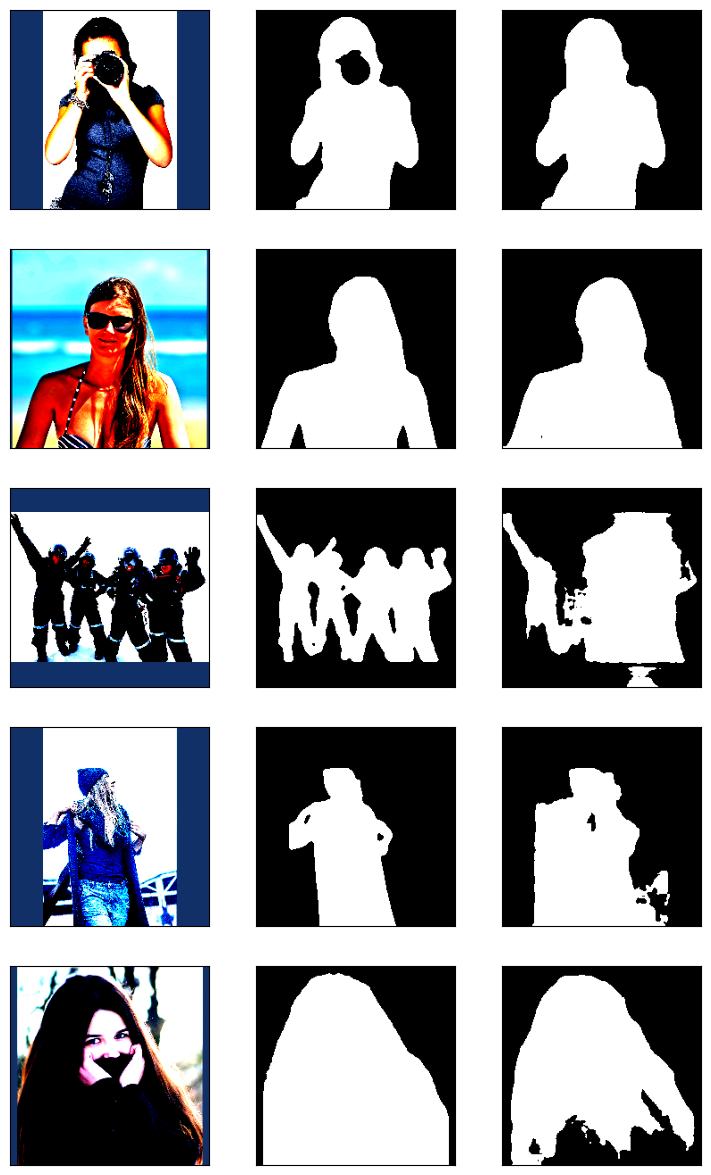

In [44]:
def calcIOU(pred, mask):
    # sum1 = mask # recall
    sum1 = pred + mask
    sum1[sum1>0] = 1.0
    sum2 = pred + mask
    sum2[sum2<2] = 0.0
    sum2[sum2>=2] = 1.0
    if np.sum(sum1) == 0:
        return 1.0
    else:
        return 1.0*np.sum(sum2)/np.sum(sum1)

def show_image(image):
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')  # 使用灰度颜色映射
    else:
        image = np.transpose(image, (1, 2, 0))
        image = image[...,::-1]
        plt.imshow(image)
    plt.axis('off')  # 关闭坐标轴
    plt.show()

def show_images(images, n_columns=2):
    n_rows = ((len(images)+1) // n_columns)
    f, axarr = plt.subplots(n_rows, n_columns, figsize=(n_columns*3,n_rows*3))
    _show = lambda sub_ax, image: sub_ax.imshow(image, cmap=None if len(image.shape) != 2 else 'gray')
    for i in range(len(images)):
        n_row, n_column = i // n_columns, i % n_columns
        image = images[i]
        sub_ax = axarr[n_row, n_column] if n_rows > 1 else axarr[n_column]
        sub_ax.get_xaxis().set_visible(False)
        sub_ax.get_yaxis().set_visible(False)

        if len(image.shape) == 2:
            _show(sub_ax, image)
            continue
        image = np.transpose(image, (1, 2, 0))
        image = image[...,::-1]
        _show(sub_ax, image)
    plt.savefig("test.pdf", format="pdf", bbox_inches="tight")

n_iteration = 0
images = []
for input_ori, input, edge, mask in test_dataloader:
    # if random.choice([True]*80 + [False]*20):
    #     continue
    input_var = input.to(args.device)
    mask_var = mask.to(args.device)
    output_mask, output_edge = model(input_var)
    output_mask = F.softmax(output_mask, dim=1)
    prob = output_mask[0,1,:,:]
    pred = prob.data.cpu().numpy()
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
    images += [input[0].numpy(), mask[0].numpy(), pred]
    # show_image(input[0].numpy())
    # # show_image(mask[0].numpy())
    # show_image(pred)
    n_iteration += 1
    if n_iteration > 4:
        break
    # print(calcIOU(pred, mask[0].numpy()))
    # break

show_images(images, n_columns=3)